In [1]:
import numpy as np
def position_1D(dimension,pos):
    assert dimension%2==0
    omega=np.arange(dimension//2,dtype=float)
    #print(omega)
    omega/=dimension/2.
    omega=1./10000**omega
    print(omega)
    pos=pos.reshape(-1)
    out=np.einsum('m,d->md',pos,omega)
    #print(out)
    Sin_out=np.sin(out)
    Cos_out=np.cos(out)
    embedding=np.concatenate([Sin_out,Cos_out],axis=1)
    return embedding
def position_2D(dimension,grid):
    embed_H=position_1D(dimension//2,grid[0])
    embed_W=position_1D(dimension//2,grid[1])
    embeding=np.concatenate([embed_H,embed_W],axis=1)
    return embeding

In [2]:
def get_2d_position_from_start(embed_dim,grid_size):
    grid_height=np.arange(grid_size,dtype=np.float32)
    grid_width=np.arange(grid_size,dtype=np.float32)
    grid=np.meshgrid(grid_width,grid_height)
    grid=np.stack(grid,axis=0)
    position=position_2D(embed_dim,grid)
    return position

In [3]:
def relative_position(embed_dim,grid_size):
    pos_embedding=get_2d_position_from_start(embed_dim,grid_size)
    relative_position=2*np.matmul(pos_embedding,pos_embedding.transpose())/pos_embedding.shape[1]
    return relative_position
import torch
from torch import nn
import math

In [4]:
def pairwise_distance(x):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_inner = -2*torch.matmul(x, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square + x_inner + x_square.transpose(2, 1)


def part_pairwise_distance(x, start_idx=0, end_idx=1):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        x_part = x[:, start_idx:end_idx]
        x_square_part = torch.sum(torch.mul(x_part, x_part), dim=-1, keepdim=True)
        x_inner = -2*torch.matmul(x_part, x.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        return x_square_part + x_inner + x_square.transpose(2, 1)


def xy_pairwise_distance(x, y):
    """
    Compute pairwise distance of a point cloud.
    Args:
        x: tensor (batch_size, num_points, num_dims)
    Returns:
        pairwise distance: (batch_size, num_points, num_points)
    """
    with torch.no_grad():
        xy_inner = -2*torch.matmul(x, y.transpose(2, 1))
        x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
        y_square = torch.sum(torch.mul(y, y), dim=-1, keepdim=True)
        return x_square + xy_inner + y_square.transpose(2, 1)

In [5]:
def dense_knn_matrix(x,k=16,relative_position=None):
    with torch.no_grad():
        x=x.transpose(2,1).squeeze(-1)
        batch_size,n_points,n_dims=x.shape
        n_part=10000

        if n_points>n_part:
            nn_idsx_list=[]
            groups=math.ceil(n_points/n_part)
            for i in range (groups):
                start_idx=n_part*i
                end_idx=min(n_points,n_part*(i+1))
                distance=part_pairwise_distance(x.detach(),start_idx,end_idx)
                if relative_position is not None:
                    distance+=relative_position[:,start_idx:end_idx]
                _,nn_idx_part=torch.topk(-distance,k=k)
                nn_idx_list+=[nn.idx_list]
            nn_idx=torch.cat(nn_idsx_list,dim=1)
        else:
            distance=pairwise_distance(x.detach())
            if relative_position is not None:
                distance+=relative_position
                _,nn_idx=torch.topk(-distance,k=k)
        center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
        return torch.stack((nn_idx,center_idx),dim=0)
def xy_dense_knn_matrix(x, y, k=16, relative_pos=None):

    with torch.no_grad():
            x = x.transpose(2, 1).squeeze(-1)
            y = y.transpose(2, 1).squeeze(-1)
            batch_size, n_points, n_dims = x.shape
            dist = xy_pairwise_distance(x.detach(), y.detach())
            if relative_pos is not None:
                dist += relative_pos
            _, nn_idx = torch.topk(-dist, k=k)
            center_idx = torch.arange(0, n_points, device=x.device).repeat(batch_size, k, 1).transpose(2, 1)
    return torch.stack((nn_idx, center_idx), dim=0)


In [6]:
class DenseDilated(nn.Module):
    def __init__(self,k=9,dilation=9,stochastic=False,epsilon=0.0):
        super(DenseDilated, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
    def forward(self,edge_index):
        if self.stochastic:
            if torch.rand(1) < self.epsilon and self.training:
                num=self.k*self.dilation
                randnum=torch.randperm(num)[:self.k]
                edge_index=edge_index[:,:,:,randnum]
            else:
                edge_index=edge_index[:,:,:,::self.dilation]
        else:
            edge_index=edge_index[:,:,:,::self.dilation]
        return edge_index

class DenseDilatedKnnGraph(nn.Module):
    """
    Find the neighbors' indices based on dilated knn
    """
    def __init__(self, k=9, dilation=1, stochastic=False, epsilon=0.0):
        super(DenseDilatedKnnGraph, self).__init__()
        self.dilation = dilation
        self.stochastic = stochastic
        self.epsilon = epsilon
        self.k = k
        self._dilated = DenseDilated(k, dilation, stochastic, epsilon)

    def forward(self, x, y=None, relative_pos=None):
        if y is not None:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            y = F.normalize(y, p=2.0, dim=1)
            ####
            edge_index = xy_dense_knn_matrix(x, y, self.k * self.dilation, relative_pos)
        else:
            #### normalize
            x = F.normalize(x, p=2.0, dim=1)
            ####
            edge_index = dense_knn_matrix(x, self.k * self.dilation, relative_pos)
        return self._dilated(edge_index)

In [7]:
from torch.nn import Sequential as Seq, Linear as Lin, Conv2d
def act_layer(act, inplace=False, neg_slope=0.2, n_prelu=1):
    # activation layer

    act = act.lower()
    if act == 'relu':
        layer = nn.ReLU(inplace)
    elif act == 'leakyrelu':
        layer = nn.LeakyReLU(neg_slope, inplace)
    elif act == 'prelu':
        layer = nn.PReLU(num_parameters=n_prelu, init=neg_slope)
    elif act == 'gelu':
        layer = nn.GELU()
    elif act == 'hswish':
        layer = nn.Hardswish(inplace)
    else:
        raise NotImplementedError('activation layer [%s] is not found' % act)
    return layer
def norm_layer(norm, nc):
    # normalization layer 2d
    norm = norm.lower()
    if norm == 'batch':
        layer = nn.BatchNorm2d(nc, affine=True)
    elif norm == 'instance':
        layer = nn.InstanceNorm2d(nc, affine=False)
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm)
    return layer
class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
def batched_index_select(x, idx):
    r"""fetches neighbors features from a given neighbor idx

    Args:
        x (Tensor): input feature Tensor
                :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times 1}`.
        idx (Tensor): edge_idx
                :math:`\mathbf{X} \in \mathbb{R}^{B \times N \times l}`.
    Returns:
        Tensor: output neighbors features
            :math:`\mathbf{X} \in \mathbb{R}^{B \times C \times N \times k}`.
    """
    batch_size, num_dims, num_vertices_reduced = x.shape[:3]
    _, num_vertices, k = idx.shape
    idx_base = torch.arange(0, batch_size, device=idx.device).view(-1, 1, 1) * num_vertices_reduced
    idx = idx + idx_base
    idx = idx.contiguous().view(-1)

    x = x.transpose(2, 1)
    feature = x.contiguous().view(batch_size * num_vertices_reduced, -1)[idx, :]
    feature = feature.view(batch_size, num_vertices, k, num_dims).permute(0, 3, 1, 2).contiguous()
    return feature

In [8]:
from torchvision.models import resnet50

class BasicConv(Seq):
    def __init__(self, channels, act='relu', norm=None, bias=True, drop=0.):
        m = []
        for i in range(1, len(channels)):
            m.append(Conv2d(channels[i - 1], channels[i], 1, bias=bias, groups=4))
            if norm is not None and norm.lower() != 'none':
                m.append(norm_layer(norm, channels[-1]))
            if act is not None and act.lower() != 'none':
                m.append(act_layer(act))
            if drop > 0:
                m.append(nn.Dropout2d(drop))

        super(BasicConv, self).__init__(*m)

        self.reset_parameters()

    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()



In [9]:
class Max_relative(nn.Module):

    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(Max_relative,self).__init__()
        self.conv1=BasicConv([in_channels*2,out_channels],act, norm, bias)
    def forward(self,x,edge_index,y=None):
        x_i=batched_index_select(x,edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j,_=torch.max(x_j-x_i,-1, keepdim=True)
        b, c, n, _ = x.shape
        x = torch.cat([x.unsqueeze(2), x_j.unsqueeze(2)], dim=2).reshape(b, 2 * c, n, _)
        return self.conv1(x)

class EdgeConv2d(nn.Module):
    """
    Edge convolution layer (with activation, batch normalization) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(EdgeConv2d, self).__init__()
        self.nn = BasicConv([in_channels * 2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        x_i = batched_index_select(x, edge_index[1])
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        max_value, _ = torch.max(self.nn(torch.cat([x_i, x_j - x_i], dim=1)), -1, keepdim=True)
        return max_value


class GraphSAGE(nn.Module):
    """
    GraphSAGE Graph Convolution (Paper: https://arxiv.org/abs/1706.02216) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GraphSAGE, self).__init__()
        self.nn1 = BasicConv([in_channels, in_channels], act, norm, bias)
        self.nn2 = BasicConv([in_channels*2, out_channels], act, norm, bias)

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j, _ = torch.max(self.nn1(x_j), -1, keepdim=True)
        return self.nn2(torch.cat([x, x_j], dim=1))


class GINConv2d(nn.Module):
    """
    GIN Graph Convolution (Paper: https://arxiv.org/abs/1810.00826) for dense data type
    """
    def __init__(self, in_channels, out_channels, act='relu', norm=None, bias=True):
        super(GINConv2d, self).__init__()
        self.nn = BasicConv([in_channels, out_channels], act, norm, bias)
        eps_init = 0.0
        self.eps = nn.Parameter(torch.Tensor([eps_init]))

    def forward(self, x, edge_index, y=None):
        if y is not None:
            x_j = batched_index_select(y, edge_index[0])
        else:
            x_j = batched_index_select(x, edge_index[0])
        x_j = torch.sum(x_j, -1, keepdim=True)
        return self.nn((1 + self.eps) * x + x_j)


class GraphConv2d(nn.Module):
    """
    Static graph convolution layer
    """
    def __init__(self, in_channels, out_channels, conv='edge', act='relu', norm=None, bias=True):
        super(GraphConv2d, self).__init__()
        if conv == 'edge':
            self.gconv = EdgeConv2d(in_channels, out_channels, act, norm, bias)
        elif conv == 'mr':
            self.gconv = Max_relative(in_channels, out_channels, act, norm, bias)
        elif conv == 'sage':
            self.gconv = GraphSAGE(in_channels, out_channels, act, norm, bias)
        elif conv == 'gin':
            self.gconv = GINConv2d(in_channels, out_channels, act, norm, bias)
        else:
            raise NotImplementedError('conv:{} is not supported'.format(conv))

    def forward(self, x, edge_index, y=None):
        return self.gconv(x, edge_index, y)


In [10]:
import torch.nn.functional as F
class Dynamic_graph(GraphConv2d):
    def __init__(self,in_channels, out_channels, kernel_size=9, dilation=1, conv='edge', act='relu',
                 norm=None, bias=True, stochastic=False, epsilon=0.0, r=1):
        super(Dynamic_graph,self).__init__(in_channels,out_channels,conv,act,norm,bias)
        self.k=kernel_size
        self.d=dilation
        self.r=r
        self.knn_graph=DenseDilatedKnnGraph(kernel_size,dilation,stochastic,epsilon)
    def forward(self,x,relative_position=None):
        B,C,H,W=x.shape
        y=None
        if self.r > 1:
            y = F.avg_pool2d(x, self.r, self.r)
            y = y.reshape(B, C, -1, 1).contiguous()
        x=x.reshape(B,C,-1,1).contiguous()
        edge_index=self.knn_graph(x,y,relative_position)
        x=super(Dynamic_graph,self).forward(x,edge_index,y)
        return x.reshape(B, -1, H, W).contiguous()

In [11]:
class  Grapher(nn.Module):
    def __init__(self,in_channels, kernel_size=9, dilation=1, conv='edge', act='relu', norm=None,
                 bias=True,  stochastic=False, epsilon=0.0, r=1, n=196, drop_path=0.0, relative_pos=False) :
        super(Grapher,self).__init__()
        self.channels = in_channels
        self.n = n
        self.r = r
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = Dynamic_graph(in_channels, in_channels * 2, kernel_size, dilation, conv,
                              act, norm, bias, stochastic, epsilon, r)
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.relative_pos = None
        if relative_pos :
            print('using relative pos')
            relative_pos_tensor=torch.from_numpy(np.float32(relative_position(in_channels,int(n**0.5)))).unsqueeze(0).unsqueeze(1)
            relative_pos_tensor = F.interpolate(
                    relative_pos_tensor, size=(n, n//(r*r)), mode='bicubic', align_corners=False)
            self.relative_pos=nn.Parameter(-relative_pos_tensor.squeeze(1),requires_grad=False)
    def _get_relative_pos(self, relative_pos, H, W):
        if relative_pos is None or H * W == self.n:
            return relative_pos
        else:
            N = H * W
            N_reduced = N // (self.r * self.r)
            return F.interpolate(relative_pos.unsqueeze(0), size=(N, N_reduced), mode="bicubic").squeeze(0)

    def forward(self, x):
        _tmp = x
        x = self.fc1(x)
        B, C, H, W = x.shape
        relative_pos = self._get_relative_pos(self.relative_pos, H, W)
        x = self.graph_conv(x, relative_pos)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [12]:
class FFN(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act='relu', drop_path=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x

In [13]:
class Stem(nn.Module):
    def __init__(self, img_size=224, in_dim=3, out_dim=768, act='relu'):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            act_layer(act),
            nn.Conv2d(out_dim//2, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
            act_layer(act),
            nn.Conv2d(out_dim, out_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.convs(x)
        return x
class Downsample(nn.Module):

    def __init__(self, in_dim=3, out_dim=768):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


In [14]:
from torch.nn import Sequential as Seq

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 6, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    'vig_224_gelu': _cfg(
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vig_b_224_gelu': _cfg(
        crop_pct=0.95, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
}
class DeepGCN(torch.nn.Module):
    def __init__(self, opt):
        super(DeepGCN, self).__init__()
        print(opt)
        k = opt.k
        act = opt.act
        norm = opt.norm
        bias = opt.bias
        epsilon = opt.epsilon
        stochastic = opt.use_stochastic
        conv = opt.conv
        emb_dims = opt.emb_dims
        drop_path = opt.drop_path

        blocks = opt.blocks
        self.n_blocks=sum(blocks)
        channels = opt.channels
        reduce_ratios = [4, 2, 1, 1]
        drop_path_rate=[x.item() for x in torch.linspace(0,drop_path,self.n_blocks)]
        num_knn=[int(x.item()) for x in torch.linspace(k,k,self.n_blocks) ]
        max_dilation=49//max(num_knn)
        self.stem=Stem(out_dim=channels[0],act=act)
        self.pos_embed=nn.Parameter(torch.zeros(1,channels[0],224//4,224//4))

        HW=224 // 4 * 224 // 4
        self.backbone=nn.ModuleList([])
        idx=0
        for i in range (len(blocks)):
            if i>0:
                self.backbone.append(Downsample(channels[i-1],channels[i]))
                HW=HW//4
            for j in range (blocks[i]):
                self.backbone.append (Seq(Grapher(channels[i],num_knn[idx],min(idx//4+1,max_dilation),conv, act, norm,
                                    bias, stochastic, epsilon, reduce_ratios[i], n=HW, drop_path=drop_path_rate[idx],
                                    relative_pos=True),
                          FFN(channels[i], channels[i] * 4, act=act, drop_path=drop_path_rate[idx])
                         ))
                idx+=1

        self.backbone = Seq(*self.backbone)


        self.prediction = Seq(nn.Conv2d(channels[-1], 1024, 1, bias=True),
                              nn.BatchNorm2d(1024),
                              act_layer(act),
                              nn.Dropout(opt.dropout),
                              nn.Conv2d(1024, opt.n_classes, 1, bias=True))
        self.model_init()
    def model_init(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True
    def forward(self,inputs):
        x=self.stem(inputs)+self.pos_embed
        B, C, H, W = x.shape
        for i in range(len(self.backbone)):
            x = self.backbone[i](x)

        x = F.adaptive_avg_pool2d(x, 1)
        return self.prediction(x).squeeze(-1).squeeze(-1)
@register_model
def pvig_ti_224_gelu(pretrained=False, **kwargs):
    class OptInit:
        def __init__(self, num_classes=6, drop_path_rate=0.3, **kwargs):
                self.k = 9 # neighbor num (default:9)
                self.conv = 'mr' # graph conv layer {edge, mr}
                self.act = 'gelu' # activation layer {relu, prelu, leakyrelu, gelu, hswish}
                self.norm = 'batch' # batch or instance normalization {batch, instance}
                self.bias = True # bias of conv layer True or False
                self.dropout = 0.3 # dropout rate
                self.use_dilation = True # use dilated knn or not
                self.epsilon = 0.2 # stochastic epsilon for gcn
                self.use_stochastic = False # stochastic for gcn, True or False
                self.drop_path = drop_path_rate
                self.blocks = [2,2,6,2] # number of basic blocks in the backbone
                self.channels = [80, 160, 400, 640]  # number of channels of deep features
                self.n_classes = num_classes # Dimension of out_channels
                self.emb_dims = 1024 # Dimension of embeddings

    opt = OptInit(**kwargs)
    model = DeepGCN(opt)
    model.default_cfg = default_cfgs['vig_224_gelu']
    return model

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter, RandomCrop
# Define transformations
transform = transforms.Compose([
    RandomHorizontalFlip(p=0.5),  # 50% probability of flipping horizontally
    RandomVerticalFlip(p=0.5),    # 50% probability of flipping vertically
    RandomRotation(degrees=15),   # Rotate by up to ±15 degrees
   
      # Crop and pad the image
    transforms.Resize((224, 224)),  # Resize to the required input dimensions
    transforms.ToTensor(),          # Convert to tensor
    # Additional transformations like normalization can be added here
])

# Download and load the VOC dataset
voc_dataset = VOCDetection(root='./data', year='2012', image_set='trainval', download=True, transform=transform)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [17]:
VOC_CLASSES = (
    "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair",
    "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
)
num_classes = len(VOC_CLASSES)


In [18]:
def process_annotations(voc_dataset):
    # Assuming that voc_dataset.classes provides the list of classes
    num_classes = len(VOC_CLASSES)
    multi_label_data = []

    for image, annotation in voc_dataset:
        label_vector = torch.zeros(num_classes, dtype=torch.float32)
        for obj in annotation['annotation']['object']:
            class_index = VOC_CLASSES.index(obj['name'])
            label_vector[class_index] = 1
        multi_label_data.append((image, label_vector))

    return multi_label_data

multi_label_dataset = process_annotations(voc_dataset)


In [19]:
VOC_CLASSES.index

<function tuple.index(value, start=0, stop=9223372036854775807, /)>

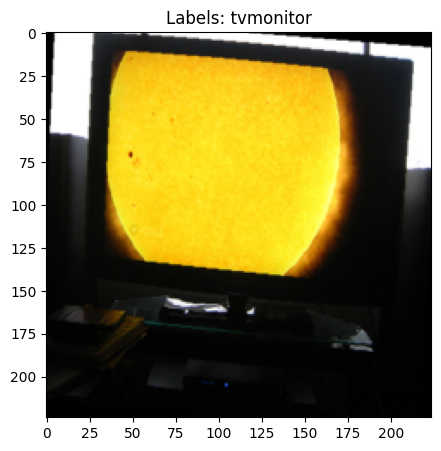

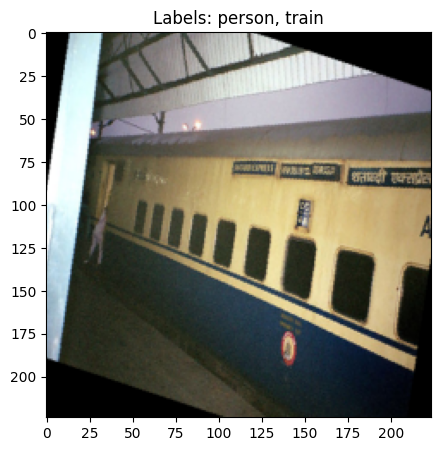

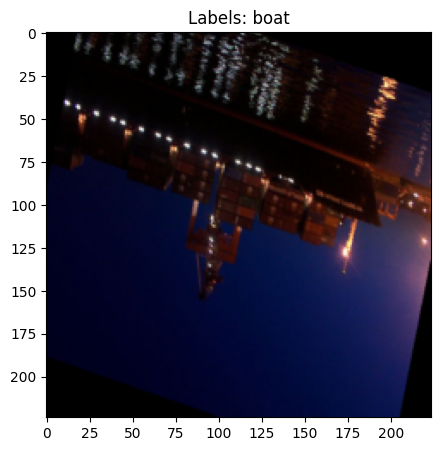

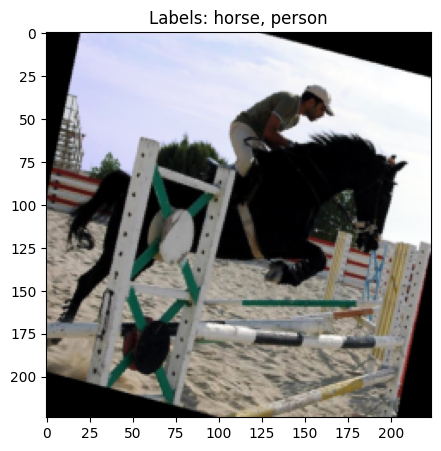

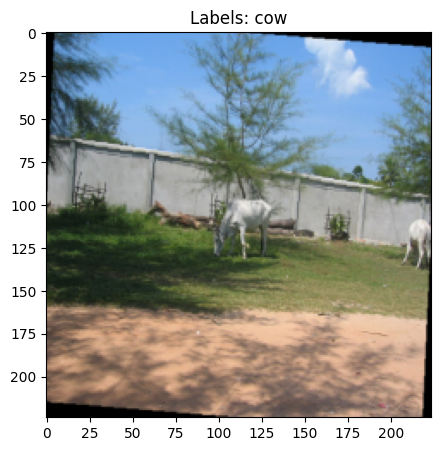

In [20]:
import matplotlib.pyplot as plt
for i, (image, label) in enumerate(multi_label_dataset):
    if i < 5:
        plt.figure(figsize=(5, 5))
        plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(f"Labels: {', '.join([VOC_CLASSES[i] for i, l in enumerate(label) if l == 1])}")
        plt.show()
    else:
        break

In [21]:
from torch.utils.data import DataLoader

from torch.utils.data import random_split

# Example split ratios
train_ratio = 0.75
val_ratio = 0.10
test_ratio = 0.15

# Calculate split sizes
total_size = len(multi_label_dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(multi_label_dataset, [train_size, val_size, test_size])
from torch.utils.data import DataLoader

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [22]:
len(VOC_CLASSES)

20

In [23]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()


<__main__.pvig_ti_224_gelu.<locals>.OptInit object at 0x7f31594c1e10>
using relative pos
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.51188643e-04 1.58489319e-04]
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.51188643e-04 1.58489319e-04]
using relative pos
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.511

using relative pos
[1.00000000e+00 9.44060876e-01 8.91250938e-01 8.41395142e-01
 7.94328235e-01 7.49894209e-01 7.07945784e-01 6.68343918e-01
 6.30957344e-01 5.95662144e-01 5.62341325e-01 5.30884444e-01
 5.01187234e-01 4.73151259e-01 4.46683592e-01 4.21696503e-01
 3.98107171e-01 3.75837404e-01 3.54813389e-01 3.34965439e-01
 3.16227766e-01 2.98538262e-01 2.81838293e-01 2.66072506e-01
 2.51188643e-01 2.37137371e-01 2.23872114e-01 2.11348904e-01
 1.99526231e-01 1.88364909e-01 1.77827941e-01 1.67880402e-01
 1.58489319e-01 1.49623566e-01 1.41253754e-01 1.33352143e-01
 1.25892541e-01 1.18850223e-01 1.12201845e-01 1.05925373e-01
 1.00000000e-01 9.44060876e-02 8.91250938e-02 8.41395142e-02
 7.94328235e-02 7.49894209e-02 7.07945784e-02 6.68343918e-02
 6.30957344e-02 5.95662144e-02 5.62341325e-02 5.30884444e-02
 5.01187234e-02 4.73151259e-02 4.46683592e-02 4.21696503e-02
 3.98107171e-02 3.75837404e-02 3.54813389e-02 3.34965439e-02
 3.16227766e-02 2.98538262e-02 2.81838293e-02 2.66072506e-02
 2.51

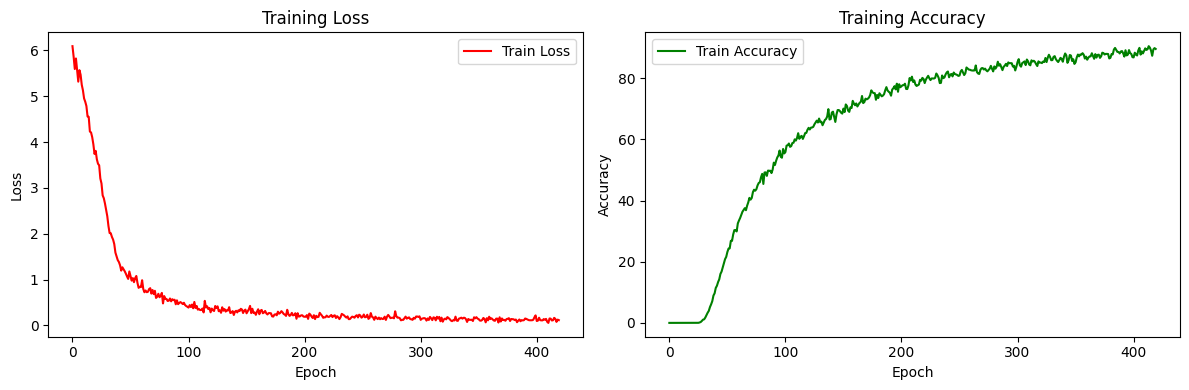

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#

#

model = pvig_ti_224_gelu(num_classes=20).to(device)
if torch.cuda.device_count() > 1:
  model = nn.DataParallel(model)


criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
5
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)


import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
sigmoid = nn.Sigmoid()

for epoch in range(420):

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    patience=10
    stop_count = 0
    min_valid_loss = float('inf')
    model.train()

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        predicted = sigmoid(outputs) > 0.3
        correct_predictions += (predicted == labels.byte()).all(dim=1).sum().item()  # check correct predictions per sample
        total_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        del inputs,labels, outputs
        torch.cuda.empty_cache()

        # print statistics
        running_loss += loss.item()
        if i % 25== 24:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')
    model.eval()
    valid_loss = 0.0
    for i, data in enumerate(val_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        predicted = sigmoid(outputs) > 0.5
        correct_predictions += (predicted == labels.byte()).all(dim=1).sum().item()  # check correct predictions per sample
        total_predictions += labels.size(0)
        #correct_predictions += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        valid_loss += loss.item()
    valid_loss /= len(val_loader.dataset)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 500, valid_loss))

    # Check for Early Stopping
    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        stop_count = 0
    else:
        stop_count += 1
        if stop_count >= patience:
            print("Early stopping")
            break

print('Finished Training')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_checkpoint_ocast_multi_voc_asym.pth')


# Now let's plot the training loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r-', label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'g-', label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize your model
model = pvig_ti_224_gelu(num_classes=20).to(device)

# Load the checkpoint
checkpoint = torch.load('model_checkpoint_ocast_multi_voc_asym.pth')

# Adjust the keys in the state dictionary
new_state_dict = {k.replace('module.', ''): v for k, v in checkpoint['model_state_dict'].items()}

# Load the state dictionary into the model
model.load_state_dict(new_state_dict)

# Load optimizer state if necessary
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5
        correct_predictions += (predicted == labels.byte()).all(dim=1).sum().item()
        total_predictions += labels.size(0)

accuracy = 100 * correct_predictions / total_predictions
print('Accuracy of the network on the test images: %d %%' % accuracy)


<__main__.pvig_ti_224_gelu.<locals>.OptInit object at 0x7f315adb6890>
using relative pos
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.51188643e-04 1.58489319e-04]
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.51188643e-04 1.58489319e-04]
using relative pos
[1.00000000e+00 6.30957344e-01 3.98107171e-01 2.51188643e-01
 1.58489319e-01 1.00000000e-01 6.30957344e-02 3.98107171e-02
 2.51188643e-02 1.58489319e-02 1.00000000e-02 6.30957344e-03
 3.98107171e-03 2.51188643e-03 1.58489319e-03 1.00000000e-03
 6.30957344e-04 3.98107171e-04 2.511

In [26]:
example_input = torch.randn(1, 3, 224, 224).to(device)  # Adjust the size based on your model's input
traced_script_module = torch.jit.trace(model, example_input)
#scripted_module = torch.jit.script(model)
traced_script_module.save("traced_model.pt")

In [27]:
model.eval()

correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        predicted = torch.sigmoid(outputs) > 0.5
        correct_predictions += (predicted == labels.byte()).all(dim=1).sum().item()  # check correct predictions per sample
        total_predictions += labels.size(0)

print('Accuracy of the network on the test images: %d %%' % (100 * correct_predictions  / total_predictions ))

Accuracy of the network on the test images: 9 %


In [28]:
def average_precision_m(output, target):
    epsilon = 1e-8

    # sort examples
    indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    target_ = target[indices]
    ind = target_ == 1
    pos_count_ = np.cumsum(ind)
    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0
    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i


def mAP(targs, preds):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        # sort scores
        scores = preds[:, k]
        targets = targs[:, k]
        # compute average precision
        ap[k] = average_precision_m(scores, targets)
    return ap,100 * ap.mean()

In [29]:
all_probabilities = []
all_labels=[]
all_predictions=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        
        # Probabilities and predictions
        probabilities =torch.sigmoid(outputs)
        predicted = probabilities > 0.5

        correct_predictions += (predicted == labels.byte()).all(dim=1).sum().item()
        total_predictions += labels.size(0)

        all_labels.append(labels.cpu().numpy())
        all_probabilities.append(probabilities.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())
import numpy as np

all_labels = np.vstack(all_labels)
all_predictions = np.vstack(all_predictions)
all_probabilities = np.vstack(all_probabilities)
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score, matthews_corrcoef, average_precision_score

# Calculate metrics
accuracy = 100 * correct_predictions / total_predictions
precision = precision_score(all_labels, all_predictions, average='samples')
recall = recall_score(all_labels, all_predictions, average='samples')
f1 = f1_score(all_labels, all_predictions, average='samples')
hamming = hamming_loss(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_probabilities)
mcc = matthews_corrcoef(all_labels.flatten(), all_predictions.flatten())
avg_precision = mAP(all_probabilities, all_labels)

# Print metrics
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Hamming Loss: {hamming:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'Matthews Correlation Coefficient: {mcc:.4f}')
print(f'Average Precision Score: {avg_precision:.4f}')
from sklearn.metrics import average_precision_score

# ... [your existing code for model evaluation]

# Calculate AP for each label
average_precisions = [average_precision_score(all_labels[:, i], all_predictions[:, i]) for i in range(all_labels.shape[1])]

# Calculate mAP by averaging over all labels
mean_avg_precision = sum(average_precisions) / len(average_precisions)
mean=map(all_labels,all_probabilities)
# Print the mAP
print(f'Mean Average Precision: {mean_avg_precision:.4f}')

print(f'Mean : {mean:.4f}')

Accuracy: 9.91%
Precision: 0.3160
Recall: 0.3758
F1 Score: 0.3184
Hamming Loss: 0.1090
ROC-AUC: 0.7378
Matthews Correlation Coefficient: 0.2799


TypeError: unsupported format string passed to tuple.__format__

In [ ]:
map(all_labels,all_probabilities)

In [ ]:
mAP(all_labels,all_probabilities)

(array([0.5359704 , 0.08017519, 0.16826493, 0.20239686, 0.11233985,
        0.26451836, 0.18586436, 0.30297042, 0.27774653, 0.08389782,
        0.13809057, 0.26253373, 0.15653296, 0.14459122, 0.65067964,
        0.09245983, 0.09831543, 0.11442255, 0.1178045 , 0.23084776]),
 21.10211465643237)

In [ ]:
all_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
all_labels[:,1].shape

(1732,)

[0.3827081454864801,
 0.08084366059997182,
 0.10888957078333522,
 0.16120074549606034,
 0.05884978929073118,
 0.23147254489676328,
 0.20907672004669692,
 0.20755493040441575,
 0.16749893952962247,
 0.027099517111064456,
 0.10080383421289765,
 0.1711903586313079,
 0.06975963212342226,
 0.11853765013357272,
 0.5233862630411394,
 0.06230372569864487,
 0.05299502044762262,
 0.07174232279516887,
 0.20773474306410303,
 0.1521092671905276]